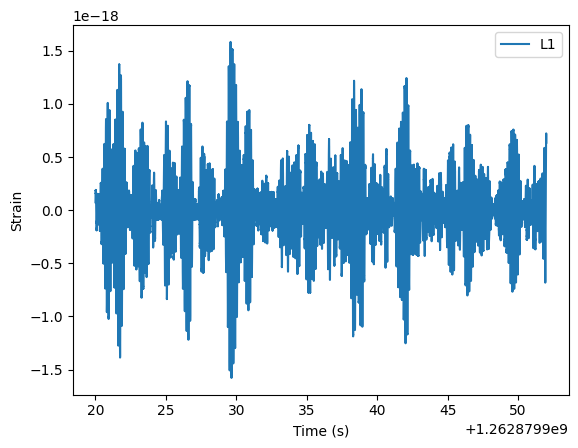

In [3]:
import matplotlib.pyplot as plt
from pycbc import catalog
m = catalog.Merger("GW200112_155838-v1", source='gwtc-3')

ts_liv = m.strain('L1')

plt.plot(ts_liv.sample_times, ts_liv, label="L1")
plt.legend()
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

Text(0.5, 0, 'Time (s)')

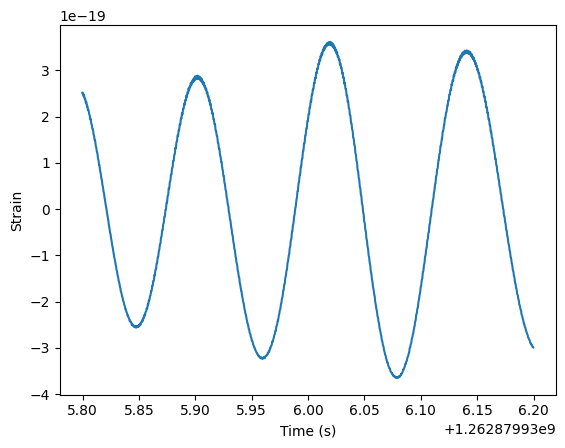

In [4]:
merge_window = ts_liv.time_slice(m.time - 0.2, m.time + 0.2 )
plt.plot(merge_window.sample_times, merge_window)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

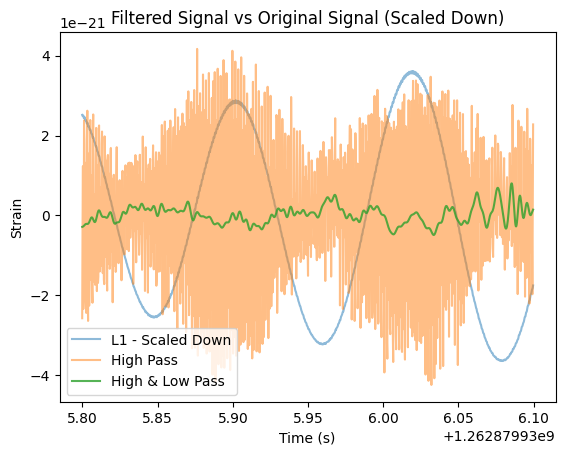

In [33]:

highpass = ts_liv.highpass_fir(30, 512)
lowpass = highpass.lowpass_fir(250, 512) # two more freq filters


# zoom in on event
event = lowpass.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, ts_liv.time_slice(m.time -0.2, m.time + 0.1) / 100, label="L1 - Scaled Down", alpha=0.5)
plt.plot(event.sample_times, highpass.time_slice(m.time -0.2, m.time + 0.1), label="High Pass", alpha=0.5)
plt.plot(event.sample_times, event, label="High & Low Pass", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Filtered Signal vs Original Signal (Scaled Down)')
plt.legend()
plt.show()

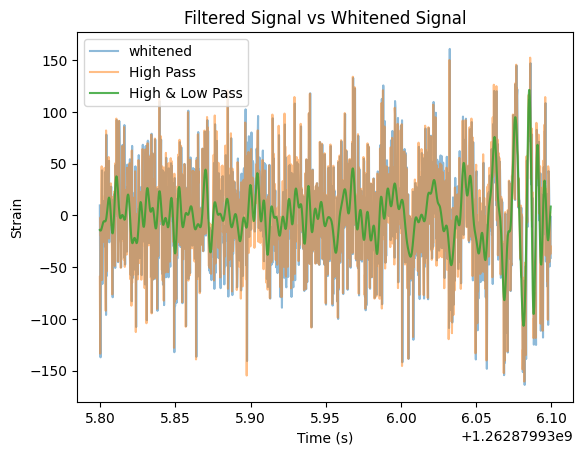

In [34]:
whitened = ts_liv.whiten(4, 4) # Flatten Freq Response of PSD
highpass = whitened.highpass_fir(30, 512)
lowpass = highpass.lowpass_fir(250, 512) # two more freq filters


# zoom in on event
event = lowpass.time_slice(m.time -0.2, m.time + 0.1)
plt.plot(event.sample_times, whitened.time_slice(m.time -0.2, m.time + 0.1), label="whitened", alpha=0.5)
plt.plot(event.sample_times, highpass.time_slice(m.time -0.2, m.time + 0.1), label="High Pass", alpha=0.5)
plt.plot(event.sample_times, event, label="High & Low Pass", alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Filtered Signal vs Whitened Signal')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.filter import matched_filter

def fir_filter(signal, lowpass, highpass):
    """Applies FIR highpass and lowpass filters to the input signal."""
    filtered_signal = signal.highpass_fir(highpass, 512)
    filtered_signal = filtered_signal.lowpass_fir(lowpass, 512)
    return filtered_signal

def snr(raw_signal, filtered_signal):
    """Calculates the signal-to-noise ratio (SNR) between the raw and filtered signals."""
    # Ensure both signals are aligned in time
    raw_signal = raw_signal.time_slice(filtered_signal.start_time, filtered_signal.end_time)
    noise = raw_signal - filtered_signal 
    signal_power = np.asarray(filtered_signal ** 2).mean()
    noise_power = np.asarray(noise ** 2).mean()
    return 10 * np.log10(signal_power / noise_power)

def snr_template(filtered_signal, template):
    """Calculates the SNR of the filtered signal against a given template."""
    # Ensure both signals are aligned in time
    filtered_signal = filtered_signal.time_slice(template.start_time, template.end_time)
    psd = interpolate(welch(filtered_signal, seg_len=4), filtered_signal.delta_f)
    snr = matched_filter(template, filtered_signal, psd=psd, low_frequency_cutoff=20)
    peak = abs(snr).max()
    return 10 * np.log10(peak)

template, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=m.mass1, mass2=m.mass2, delta_f=whitened.delta_f, f_lower=20)
f_range = np.linspace(1, 512, 100)
snr_results = np.zeros((len(f_range), len(f_range)))
whitened = ts_liv.whiten(4, 4) # Flatten Freq Response of PSD

    

USE_TEMPLATE_SNR = True

def trial(band): 
    """Runs a trial of FIR filtering and SNR calculation."""
    lowpass, highpass = band
    filtered_signal = fir_filter(whitened, lowpass, highpass)
    if USE_TEMPLATE_SNR:
        return snr_template(filtered_signal, template)
    else:
        return snr(whitened, filtered_signal)

bands = [(lp, hp) for lp in f_range for hp in f_range]

results = process_map(
    trial,
    bands, chunksize=len(bands) // 10
)

snr_results = np.array(results).reshape(len(f_range), len(f_range))
plt.imshow(snr_results, extent=(1, 512, 1, 512), origin='lower', aspect='auto')
plt.colorbar(label='SNR (dB)')
plt.xlabel('Highpass Frequency (Hz)')
plt.ylabel('Lowpass Frequency (Hz)')
plt.title('SNR Heatmap for FIR Filter Parameters')
plt.show()



  0%|          | 0/10000 [00:00<?, ?it/s]